In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns, load_run, extract_best_entries, equalize_by
from IPython.display import display, Image as IPImage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
load_existing_run = None

if load_existing_run is None:
    num_cats = 10
    entries_per_cat = 1000
    image_gen_params = {
        'magnification': 1,
        'resolution': 32,
        'invert_color': True,
        'stroke_width_scale': 1
    }
    
    # files = get_dataset_files()
    # files = random.sample(files, num_cats)
    names = ['power outlet', 'pickup truck', 'castle']
    # names = ['ambulance','bed','bench','bread','castle','cell phone','chair','church','coffee cup','crown','cruise ship','cup','dishwasher','dresser','eye','face',
        # 'fan','fire hydrant','fish','hammer','hat','helicopter','ice cream','lantern','passport','pickup truck','pillow','power outlet','sailboat','sandwich','snowman','star',
        # 'strawberry','suitcase','table','telephone','traffic light','watermelon','wine glass']
    files = list(map(lambda n: f"./dataset/{n}.ndjson", names))
    df = extract_first_entries(files, entries_per_cat, recognized=True)
    
    print(f'Loaded {len(df)} entries from {files}')
    # df = equalize_by(df, 'countrycode')
    # print(f'Kept {len(df)} entries')
    df = df.sample(len(df))
    print('Done shuffling dataset')
    df = generate_pixel_columns(df, **image_gen_params).reset_index(drop=True)
    print('Done generating pixel columns')

else:
    run = load_run(load_existing_run)
    df = run['data']
    num_cats = len(df['word'].value_counts())
    entries_per_cat = df['word'].value_counts()[df['word'].value_counts().keys()[0]]
    image_gen_params = run['img_params']
    

Loaded 3000 entries from ['./dataset/power outlet.ndjson', './dataset/pickup truck.ndjson', './dataset/castle.ndjson']
Done shuffling dataset
Done generating pixel columns


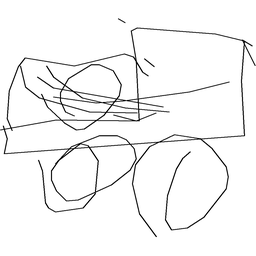

pickup truck


In [5]:
img = df.sample().iloc[0]
display(IPImage(render_single(img['drawing'])))
print(img['word'])

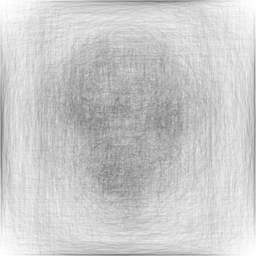

1000 superimposed power outlets.


In [6]:
count = 1000 if entries_per_cat > 1000 else entries_per_cat
word = random.choice(df['word'].values)
imgs = df[df['word'] == word].sample(count)
display(IPImage(render_multiple(imgs['drawing'])))
print(f'{count} superimposed {word}s.')

In [7]:
train_amt = int(len(df) * .9)

train = df[:train_amt]
test = df[train_amt:]
# del df

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

Train: 2700 entries, test: 300 entries.


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_on = True

y = train['word'].to_numpy()
X = train.filter(regex='pixel.+').to_numpy()
print("Done generating features and target")

if pca_on:
    if load_existing_run is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(.85)
        X = pca.fit_transform(X)
        print(f'PCA & standardization done. Keeping {pca.n_components_} features')
    else:
        scaler = run['scaler']
        pca = run['pca']
        X = scaler.transform(X)
        X = pca.transform(X)
        print('Applied scaler and PCA.')

save_to_disk = False

if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    with open(folder + 'img_params', 'w') as f:
        f.writelines(str(image_gen_params))
    print('Done saving dataset to disk')
    if pca_on:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(scaler, folder + 'scaler')
        print('Done saving PCA and scaler to disk')

Done generating features and target
PCA & standardization done. Keeping 431 features


In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from itertools import repeat

# Which class does this instance belong to?
# in a multiclass classification problem can be reduced to:
#  for each class in classes:
#    does this instance belong to class? -> probability
#  return the class with the highest probability

classifiers = {
    # 'LinearSVC': LinearSVC(dual=False),
    # 'NuSVC': NuSVC(nu=.01),
    # 'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1),
    'SVC': SVC(kernel='rbf', C=2.5, gamma=.0001105),
    # 'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(store_covariance=True),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(store_covariance=True),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=tuple(repeat(int(pca.n_components_ * 1.2), 3)), solver='lbfgs', alpha=1e-07),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'ExtraTreeClassifier': ExtraTreeClassifier(),
    # 'KernelRidge': KernelRidge(),
    # 'GaussianProcess': GaussianProcessClassifier(1.0 * RBF(1.0)),
}

models = {}
start = time.time()
for type, classifier in classifiers.items():
    models[type] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    end = time.time()
    print(f"Done training {type} model in {'{:.2f}'.format(end - start)}s")
    start = end

if save_to_disk:
    joblib.dump(models, folder + 'models')
    print("Done saving models to disk")

Done training SVC model in 1.64s
Done training QuadraticDiscriminantAnalysis model in 0.59s
Done training MLPClassifier model in 11.84s


import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, multilabel_confusion_matrix
from itertools import product

import numpy as np
cls_type, model = random.choice(list(models.items()))

test_data = test.filter(regex='pixel.+').to_numpy()
test_data = pca.transform(scaler.transform(test_data))

countries = test['countrycode'].value_counts().keys()
predictions = model.predict(test_data)
truth = test['countrycode'].to_numpy()

conf_matrix = {}
for index in range(len(predictions)):
    pred = predictions[index]
    act = truth[index]
    score = conf_matrix.get((pred, act), 0)
    conf_matrix[(pred, act)] = score + 1

# print('    ' + '  '.join(countries))
# for i in range(len(countries)):
#     print(countries[i] + ' ' + ' '.join(list(map(lambda e : str(conf_matrix.get((countries[i], e), 0)).rjust(3), countries))))


results = {}
for country in countries:
    tp = conf_matrix.get((country, country), 0)
    fn = sum(list(map(lambda item : conf_matrix.get((item, country), 0) if country != item else 0, countries)))
    fp = sum(list(map(lambda item : conf_matrix.get((country, item), 0) if country != item else 0, countries)))
    tn = sum([conf_matrix.get(entry, 0) for entry in product(countries, countries) if (entry[0] != country and entry[1] != country)])

    beta = 1.0
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    sensitivity = 0 if tp == 0 and fn == 0 else tp / (tp + fn)
    specificity = 0 if fp == 0 and tn == 0 else tn / (fp + tn)
    precision = 0 if tp == 0 and fp == 0 else tp / (tp + fp)
    recall = sensitivity
    f_score = 'Precision and recall are 0, can\'t calculate' if precision == 0 and recall == 0 else ( (beta**2 + 1) * precision * recall) / (beta**2 * precision + recall)
    auc = (sensitivity + specificity) / 2
    youden = sensitivity - (1 - specificity)
    p_plus = 'Specificity is 1, can\'t calculate' if specificity == 1 else sensitivity / (1 - specificity)
    p_minus = (1 - sensitivity) / specificity
    dp = 'Specificity is 1, can\'t calculate' if specificity == 1 else (np.sqrt(3) / np.pi) * (np.log(sensitivity/(1 - sensitivity) + np.log(specificity/(1 - specificity))))

    result = {}
    result["tp"] = tp
    result["tn"] = tn
    result["fp"] = fp
    result["fn"] = fn
    result["accuracy"] = accuracy
    result["sensitivity"] = sensitivity
    result["specificity"] = specificity
    result["precision"] = precision
    result["recall"] = recall
    result["f-score"] = f_score
    result["AUC"] = auc
    result["Youden"] = youden
    result["p+"] = p_plus
    result["p-"] = p_minus
    result["DP"] = dp

    # for k, v in result.items():
    #     print(f'{k}: {"{:.2f}".format(v)}')

    results[country] = result

pro = 1
for k, v in results.items():
    print(f'{k}: {v["accuracy"]}')
    pro *= v['accuracy'] if v['accuracy'] > 0 else 1
print(pro)

print(classification_report(truth, predictions, zero_division=0))

print(accuracy_score(truth, predictions, normalize=True))


classes = ['A', 'B', 'C']
truth = ['C', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'A']
predictions = ['A', 'C', 'A', 'B', 'A', 'B', 'C', 'A', 'B', 'A']

conf_matrix = {}
for index in range(len(predictions)):
    pred = predictions[index]
    act = truth[index]
    score = conf_matrix.get((pred, act), 0)
    conf_matrix[(pred, act)] = score + 1

accs = []
for country in classes:
    tp = conf_matrix.get((country, country), 0)
    fn = sum(list(map(lambda item : conf_matrix.get((item, country), 0) if country != item else 0, classes)))
    fp = sum(list(map(lambda item : conf_matrix.get((country, item), 0) if country != item else 0, classes)))
    tn = sum(list(map(lambda item : conf_matrix.get((item[0], item[1]), 0) if item[0] != country and item[1] != country else 0, zip(classes, classes))))
    print(country, tp, fn, fp, tn)

    acc = 0 if tp + tn + fn + fp == 0 else (tp + tn) / (tp + tn + fn + fp)
    print(acc)
    accs.append(acc)

print(classification_report(truth, predictions, zero_division=0))
print(sum(accs) / len(accs))

print(results)
print(sum([v['accuracy'] for k, v in results.items() if isinstance(v['accuracy'], float)]) / len(results))


import random

classes = ['A', 'B', 'C']

truth = ['C', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'A']
pred = ['A', 'C', 'A', 'B', 'A', 'B', 'C', 'A', 'B', 'A']

# print(truth)
# print(pred)

tp = 4
fn = 6
fp = 6
tn = 14

beta = 1.0
accuracy = (tp + tn) / (tp + fp + fn + tn)
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
precision = tp / (tp + fp)
recall = sensitivity
f_score = ( (beta**2 + 1) * precision * recall) / (beta**2 * precision + recall)
auc = (sensitivity + specificity) / 2
youden = sensitivity - (1 - specificity)
p_plus = sensitivity / (1 - specificity)
p_minus = (1 - sensitivity) / specificity
dp = (np.sqrt(3) / np.pi) * (np.log(sensitivity/(1 - sensitivity) + np.log(specificity/(1 - specificity))))

result = {}
result["tp"] = tp
result["tn"] = tn
result["fp"] = fp
result["fn"] = fn
result["accuracy"] = accuracy
result["sensitivity"] = sensitivity
result["specificity"] = specificity
result["precision"] = precision
result["recall"] = recall
result["f-score"] = f_score
result["AUC"] = auc
result["Youden"] = youden
result["p+"] = p_plus
result["p-"] = p_minus
result["DP"] = dp

for k, v in result.items():
    print(f'{k}: {"{:.2f}".format(v)}')

print(accuracy_score(truth, pred, normalize=True))



import random
cls_type, model = random.choice(list(models.items()))
# model = models['SVC']

sample = test.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(f"Using {cls_type} classifier")
print(f"{prediction[0]}(predicted) == {sample['word'].iloc[0]}(actual) ? {sample['word'].iloc[0] == prediction[0]}")

In [12]:
for model_type, model in models.items():
    test2 = test.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    if pca_on:
        test2 = scaler.transform(test2)
        test2 = pca.transform(test2)
    prediction = model.predict(test2)

    from sklearn.metrics import accuracy_score
    acc_score = accuracy_score(test['word'].values.tolist(), prediction)
    print(f"{model_type} classifier, accuracy: {acc_score}")

SVC classifier, accuracy: 0.7633333333333333
QuadraticDiscriminantAnalysis classifier, accuracy: 0.8
MLPClassifier classifier, accuracy: 0.7966666666666666


LinearSVC classifier, accuracy: 0.9208

NuSVC classifier, accuracy: 0.9756

SVC classifier, accuracy: 0.9696

LinearDiscriminantAnalysis classifier, accuracy: 0.902

QuadraticDiscriminantAnalysis classifier, accuracy: 0.9332

MLPClassifier classifier, accuracy: 0.9708

KernelRidge classifier, accuracy: 0.9036